In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from datasets import load_dataset, concatenate_datasets
import json
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt
import math
from model import Encoder


/home/hshapour/anaconda3/envs/pytorch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# hyperparameters
hyper_params = {
    "batch_size": 900, # how many independent sequences will we process in parallel?
    "block_size": 400, # what is the maximum context length for predictions?
    # "device" : 'cuda' if torch.cuda.is_available() else 'cpu',
    "n_embd" : 128, #384
    "n_head" : 4,
    "n_layer" : 6,
    "dropout" : 0.2,
    "vocab_size" : 4
    }
# ------------
device = 'cuda' if torch.cuda.is_available() else 'cpu'

d_max = 9
d = 9 # must be an odd number
model = Encoder(hyper_params)
m = model.to(device)

# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters()), 'parameters')

# p_err_train = 0.1
# p_err_val = 0.15
# dataset = load_dataset("json", data_files={
#         'train' : f"datasets/train_eos_original_mixed_{d_max}_p_{p_err_train:.2f}.json",
#         'val' : f"datasets/val_eos_original_mixed_{d_max}_p_{p_err_val:.2f}.json"
#         # 'train' : f"datasets/train_eos_original_d_{d}_p_{p_err_train:.2f}.json",
#         # 'val' : f"datasets/val_eos_original_d_{d}_p_{p_err_val:.2f}.json"
#     })

# pad_token = 3.0
# def collate_fn(examples):
#     target = [example['target'] for example in examples]
#     dist = [example['dist'] for example in examples]
#     input = []
#     attn_mask = []
#     for idx, example in enumerate(examples):
#         input.append(example['input'] + [pad_token]*(d_max**2 - dist[idx]**2))
#         attn_mask.append( [1.0]*(dist[idx]**2+1) + [0.0]*(d_max**2 - dist[idx]**2))
#     return {'input': input, 'target': target, 'dist': dist, 'attn_mask': attn_mask}

# data_loader = DataLoader(dataset["train"], batch_size=batch_size, collate_fn=collate_fn)#, shuffle = True)
# data_loader_val = DataLoader(dataset["val"], batch_size=batch_size, collate_fn=collate_fn)#, shuffle = True)
# # print(dataset["val"])

1239554 parameters


In [3]:
batch_size = 1000
p_err_train = 0.1
p_err_val = 0.15

d_list = [5,7,9,11]
d_max = max(d_list)
d = d_list[0]
mixed_dataset = load_dataset("json", data_files={
        'train' : f"datasets/train_spiral_eos_d_{d}_p_{p_err_train:.2f}.json",
        'val' : f"datasets/val_spiral_eos_d_{d}_p_{p_err_val:.2f}.json",
    })
for d in d_list:
    dataset = load_dataset("json", data_files={
            'train' : f"datasets/train_spiral_eos_d_{d}_p_{p_err_train:.2f}.json",
            'val' : f"datasets/val_spiral_eos_d_{d}_p_{p_err_val:.2f}.json",
        })
    mixed_dataset['train'] = concatenate_datasets([mixed_dataset['train'],dataset['train']])
    mixed_dataset['val'] = concatenate_datasets([mixed_dataset['val'],dataset['val']])

# print(mixed_dataset[:2])
pad_token = 3.0
def collate_fn(examples):
    target = [example['target'] for example in examples]
    dist = [example['dist'] for example in examples]
    input = []
    attn_mask = []
    for idx, example in enumerate(examples):
        input.append(example['input'] + [pad_token]*((d_max+1)**2 - (dist[idx]+1)**2))
        attn_mask.append( [1.0]*((dist[idx]+1)**2+2) + [0.0]*((d_max+1)**2 - (dist[idx]+1)**2))
    return {'input': input, 'target': target, 'dist': dist, 'attn_mask': attn_mask}

data_loader = DataLoader(mixed_dataset['train'], batch_size=batch_size, collate_fn=collate_fn, shuffle = True)
data_loader_val = DataLoader(mixed_dataset['val'], batch_size=batch_size, collate_fn=collate_fn, shuffle = True)


Generating train split: 200000 examples [00:00, 546044.46 examples/s]
Generating val split: 10000 examples [00:00, 482026.34 examples/s]
Generating train split: 200000 examples [00:00, 350145.24 examples/s]
Generating val split: 10000 examples [00:00, 360171.40 examples/s]
Generating train split: 200000 examples [00:00, 251140.36 examples/s]
Generating val split: 10000 examples [00:00, 125134.37 examples/s]
Generating train split: 200000 examples [00:01, 114314.60 examples/s]
Generating val split: 10000 examples [00:00, 96419.67 examples/s]


In [29]:
# pad_token = 3.0
# def collate_fn(examples):
#     target = [example['target'] for example in examples]
#     dist = [example['dist'] for example in examples]
#     input = []
#     attn_mask = []
#     for idx, example in enumerate(examples):
#         # print(example['input'])
#         # print([pad_token]*(d_max**2 - dist[idx]**2))
#         # print(example['input'] + [pad_token]*(d_max**2 - dist[idx]**2))
#         input.append(example['input'] + [pad_token]*(d_max**2 - dist[idx]**2))
#         attn_mask.append( [1.0]*(dist[idx]**2+1) + [float('-inf')]*(d_max**2 - dist[idx]**2))
#     # input = [example['input'] for example in examples]
#     return {'input': input, 'target': target, 'dist': dist, 'attn_mask': attn_mask}

batch_size = 100
data_loader_val = DataLoader(mixed_dataset['val'], batch_size=batch_size, collate_fn=collate_fn, shuffle = True)

for batch in data_loader_val:
    print(batch['dist'])
    X = torch.tensor(batch['input']).to(device, dtype= torch.int32)
    attn_mask = torch.tensor(batch['attn_mask']).to(device, dtype= torch.float32)
    Y = torch.tensor(batch['target']).to(device)
    # probs, loss = model(X, attn_mask, Y)
    # last_token = torch.sum(attn_mask, dim=-1).to(torch.int32)
    # print(last_token)
    # print(X[torch.arange(batch_size),last_token-1])
    
    print(X.shape)
    print(attn_mask.shape)
    # print(Y.shape)
    # print(attn_mask.shape)
    break
# print(X.shape)
# print(probs)

[5, 9, 7, 7, 9, 7, 5, 5, 5, 7, 7, 7, 5, 9, 9, 5, 5, 5, 5, 9, 7, 7, 5, 5, 9, 5, 5, 5, 5, 5, 7, 5, 5, 9, 7, 5, 9, 7, 7, 5, 5, 9, 5, 5, 5, 5, 5, 9, 9, 5, 7, 5, 5, 5, 7, 9, 5, 9, 5, 7, 9, 7, 9, 5, 9, 7, 5, 5, 9, 7, 5, 9, 5, 5, 5, 5, 9, 5, 5, 5, 5, 5, 7, 7, 5, 9, 9, 5, 9, 7, 5, 5, 5, 9, 9, 7, 7, 7, 9, 5]
torch.Size([100, 102])
torch.Size([100, 102])


In [4]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    # for split in ['train', 'val']:
    losses = torch.zeros(eval_iters)
    i = 0
    # data_loader_loss = DataLoader(dataset["train"], batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
    for batch in data_loader:
        if i >= eval_iters:
            break
        X = torch.tensor(batch['input']).to(device, dtype= torch.int32)
        attn_mask = torch.tensor(batch['attn_mask']).to(device, dtype= torch.float32)
        Y = torch.tensor(batch['target']).to(device)
        _, loss = model(X, attn_mask, Y)

        losses[i] = loss.item()
        i += 1
    out["train"] = losses.mean()

    i = 0
    out["val"] = 0
    for batch in data_loader_val:
        X = torch.tensor(batch['input']).to(device, dtype= torch.int32)
        attn_mask = torch.tensor(batch['attn_mask']).to(device, dtype= torch.float32)
        Y = torch.tensor(batch['target']).to(device)
        _, loss = model(X, attn_mask, Y)

        out["val"] += loss.item()
        i += 1
    out["val"] /= i
    
    model.train()
    return out

def estimate_accuracy():
    model.eval()
    i = 0
    acc = 0
    for batch in data_loader_val:
        # X = torch.tensor(batch['input']).to(device)
        X = torch.tensor(batch['input']).to(device, dtype= torch.int32)
        attn_mask = torch.tensor(batch['attn_mask']).to(device, dtype= torch.float32)
        Y = torch.tensor(batch['target']).to(device)
        err_probs, _ = model(X, attn_mask)
        pred = (err_probs > 0.5).to(Y)
        # print(err_probs.shape, Y.shape)
        acc += torch.sum(pred == Y, dim=(0,1))/Y.shape[0]/2
        i += 1
    acc /= i
    
    model.train()
    return acc.item()


In [5]:
learning_rate = 3e-4
# # create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

eval_interval = 100
eval_iters =  10
num_epochs = 100

loss_train = []
loss_val = []
acc_val = []
for epoch in range(num_epochs):
    iter = 0
    
    # data_loader = DataLoader(dataset["train"], batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
    for i_b, batch in enumerate(data_loader):
        # # if i_b>= eval_iters:
        # #     break
        # # # every once in a while evaluate the loss on train and val sets
        # # if epoch % 10 == 0:
        if iter % eval_interval == 0:
            losses = estimate_loss()
            acc = estimate_accuracy()
            print(f"epoch, step {epoch, iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}, val acc {acc:.4f}")
            loss_train.append(losses['train'])
            loss_val.append(losses['val'])
            acc_val.append(acc)
        X = torch.tensor(batch['input']).to(device, dtype= torch.int32)
        attn_mask = torch.tensor(batch['attn_mask']).to(device, dtype= torch.float32)
        Y = torch.tensor(batch['target']).to(device)
        _, loss = model(X, attn_mask, Y)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        iter += 1



epoch, step (0, 0): train loss 1.3874, val loss 1.3870, val acc 0.4800
epoch, step (0, 100): train loss 1.1028, val loss 1.2486, val acc 0.6154
epoch, step (0, 200): train loss 1.0718, val loss 1.2412, val acc 0.6212
epoch, step (0, 300): train loss 1.0598, val loss 1.2352, val acc 0.6183
epoch, step (0, 400): train loss 1.0450, val loss 1.2361, val acc 0.6198
epoch, step (0, 500): train loss 0.9322, val loss 1.1823, val acc 0.6587
epoch, step (0, 600): train loss 0.8585, val loss 1.1291, val acc 0.6787
epoch, step (0, 700): train loss 0.8292, val loss 1.1092, val acc 0.6939


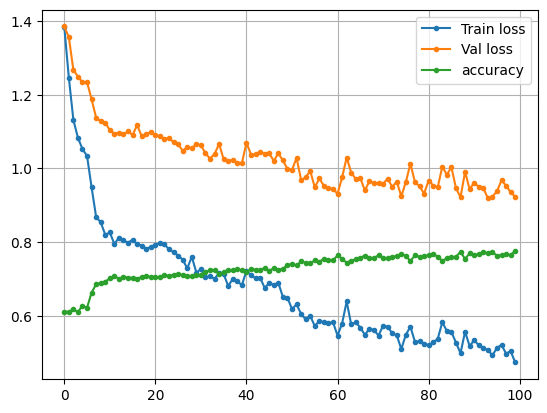

In [6]:
plt.plot(loss_train,".-",label="Train loss")
plt.plot(loss_val,".-",label="Val loss")
plt.plot(acc_val,".-",label="accuracy")
# plt.xlim([0,250])
# plt.ylim([0,1])
plt.grid()
plt.legend()


In [ ]:
# PATH = f"models/enc_pad_eos_{n_layer}_lr_{learning_rate:.4f}_dtrained_{d}.pt"
PATH = f"model_params/eos_att_mask_{n_layer}_lr_{learning_rate:.4f}_dm_{d_max}.pt"

# saving the state
# model.to(device)
# torch.save(model.state_dict(), PATH)
checkpoint = {
    "epoch": 100,
    "model_hyperparams": hyper_params,
    "model_state": model.state_dict(),
    "optim_state": optimizer.state_dict(),
}
# print(optimizer.state_dict())
# FILE = "checkpoint.pth"
torch.save(checkpoint, PATH)

In [ ]:
# hyperparameters
hyper_params = {
    "batch_size": 900, # how many independent sequences will we process in parallel?
    "block_size": 400, # what is the maximum context length for predictions?
    # "device" : 'cuda' if torch.cuda.is_available() else 'cpu',
    "n_embd" : 128, #384
    "n_head" : 4,
    "n_layer" : 6,
    "dropout" : 0.2,
    "vocab_size" : 4
    }
# ------------

learning_rate = 3e-4
FILE = f"model_params/eos_att_mask_{n_layer}_lr_{learning_rate:.4f}_dm_{d_max}.pt"

device = "cuda" if torch.cuda.is_available() else "cpu"

model = Encoder(hyper_params)

optimizer = torch.optim.AdamW(model.parameters(), lr=0)
# optimizer = torch.optim.SGD(model.parameters(), lr=0)
checkpoint = torch.load(FILE)
model.load_state_dict(checkpoint['model_state'])
optimizer.load_state_dict(checkpoint['optim_state'])
epoch = checkpoint['epoch']

# model.load_state_dict(torch.load(PATH))
model.to(device)

In [8]:
def collate_fn(examples):
    input = [example['input'] for example in examples]
    target = [example['target'] for example in examples]
    return {'input': input, 'target': target}


batch_size = 1000
p_err_list = torch.arange(0.01,0.31,0.01)
d_list = torch.arange(5,12,2)
acc = torch.zeros((p_err_list.shape[0],len(d_list)))
for i_d,d in enumerate(d_list):
    
    model.eval()
    for i_p, p_err in enumerate(p_err_list):
        dataset = load_dataset("json", data_files={
                'test' : f"datasets/test_spiral_eos_d_{d}_p_{p_err:.2f}.json",
            })
        data_loader_test = DataLoader(dataset["test"], batch_size=batch_size, collate_fn=collate_fn)

        with torch.no_grad():
            for i_b, batch in enumerate(data_loader_test):
                X = torch.tensor(batch['input']).to(device, dtype= torch.int32)
                Y = torch.tensor(batch['target']).to(device)
                err_probs, _ = model(X)
                pred = (err_probs > 0.5).to(Y)
                acc[i_p,i_d] += torch.sum(pred == Y, dim=(0,1)).item()/Y.shape[0]/2
            # print(i_b)
            acc[i_p,i_d] /= (i_b+1)

# model.train()
# del model


Generating test split: 1000 examples [00:00, 122611.79 examples/s]
Generating test split: 1000 examples [00:00, 153294.98 examples/s]
Generating test split: 1000 examples [00:00, 147375.40 examples/s]
Generating test split: 1000 examples [00:00, 158437.05 examples/s]
Generating test split: 1000 examples [00:00, 143169.85 examples/s]
Generating test split: 1000 examples [00:00, 147728.37 examples/s]
Generating test split: 1000 examples [00:00, 147957.67 examples/s]
Generating test split: 1000 examples [00:00, 154914.28 examples/s]
Generating test split: 1000 examples [00:00, 153266.97 examples/s]
Generating test split: 1000 examples [00:00, 144566.37 examples/s]
Generating test split: 1000 examples [00:00, 138371.07 examples/s]
Generating test split: 1000 examples [00:00, 141308.00 examples/s]
Generating test split: 1000 examples [00:00, 149316.63 examples/s]
Generating test split: 1000 examples [00:00, 142755.66 examples/s]
Generating test split: 1000 examples [00:00, 142093.10 example

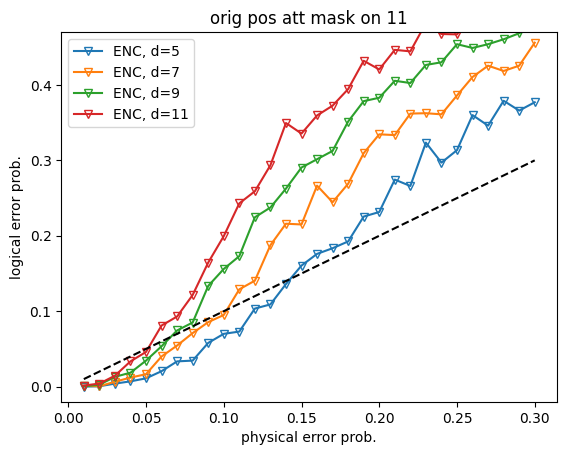

In [9]:
def mwpm_file_reader(d):
    fname = f"results/mwpm_sweep_d_{d}.json"
    f = open(fname)
    data = json.load(f)
    f.close()
    return data['p_err'], data['logical_err']

for i_d, d in enumerate(d_list):
    # p_err_list,logical_err_mwpm = mwpm_file_reader(d)
    # plt.plot(p_err_list,logical_err_mwpm,".--", color= f"C{i_d}",label=f"MWPM, d={d}")
    plt.plot(p_err_list,1-acc[:,i_d],"v-", color= f"C{i_d}",markerfacecolor="None",label=f"ENC, d={d}")

plt.plot(p_err_list,p_err_list,"k--")
plt.title(f"orig pos att mask on {d_max}")
plt.ylim([-0.02,0.47])
# plt.yscale("log")
plt.xlabel("physical error prob.")
plt.ylabel("logical error prob.")
plt.legend()
